# 第一組讀書會W11


連接雲端資料夾

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/social media/第一組讀書會') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['Group_HW_2.ipynb', 'dict', 'data']

In [ ]:
!pip install scikit-learn-extra
!pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 46.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314459 sha256=fd30c9e60da0d14c819fb0c3f651d8a383e880b9da37303f882e6f561de928b0
  Stored in directory: /root/.cache/pip/wheels/c9/69/31/d56d90b22a1777b0b231e234b00302a55be255930f8bd92dcd
Successfully built jieba


In [ ]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")


### 資料前處理

讀入Stock_data_fresh.csv資料集

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [ ]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./data/Stock_data_fresh.csv')
origin_data.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,enouch777,Stock,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""devidevi"", ""...",111.184.170.175,2023-03-21 02:21:56,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,2023-03-21 08:03:41,YU1225,Stock,今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sdhpipt"", ""c...",106.1.120.140,2023-03-22 02:22:39,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 08:14:29,peter98,Stock,技術分析的問題是 公說公有理 婆說婆有理\n\n你一旦說他沒道理 就有屁孩會來跟你說是...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Altair"", ""cm...",73.195.162.171,2023-03-22 02:22:39,ptt
3,4,https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,2023-03-21 09:32:58,YukiTW,Stock,有一招技術分析，你可能聽過，\n就是創新高的股票，上無壓力，會繼續延伸氣勢，\n簡單來說，就...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""slayptter"", ...",101.136.205.85,2023-03-22 02:22:39,ptt
4,5,https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...,[新聞]外資大砍金融股！中信金遭賣15.73萬張最,2023-03-21 10:09:52,allfate,Stock,原文標題：\n\n外資大砍金融股！中信金遭賣15.73萬張最慘 新光金、玉山金同步遭砍\n原...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""sexybox"", ""c...",42.79.171.144,2023-03-22 02:22:39,ptt


In [ ]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

Building prefix dict from /content/drive/MyDrive/social media/第一組讀書會/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/social media/第一組讀書會/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ue68d03ac3202bbcbd312507864f8947e.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.ue68d03ac3202bbcbd312507864f8947e.cache
Loading model cost 1.650 seconds.
DEBUG:jieba:Loading model cost 1.650 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空,"[標的, 星宇, 航空]"
1,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,分類討論,[討論]
2,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西,"[剛剛, 頻道, 邦尼, 測試, 星宇, 經濟艙, 東西]"
3,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,快充,[快充]
4,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,雖然實測都不到看影片真的比較接近在操作平板還可以玩憤怒鳥就知道至少有一定流暢度免費可以傳訊息...,"[實測, 不到, 影片, 接近, 操作, 平板, 憤怒, 至少, 流暢, 免費, 訊息, 吸..."
...,...,...,...,...,...,...,...
116246,2867,https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...,[請益]為什麼不是選期貨是選正二？,2024-03-21 19:11:51,我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....,期貨賺得快多了,[期貨]
116247,2867,https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...,[請益]為什麼不是選期貨是選正二？,2024-03-21 19:11:51,我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....,我知道期貨會有斷頭的問題,"[期貨, 斷頭]"
116248,2867,https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...,[請益]為什麼不是選期貨是選正二？,2024-03-21 19:11:51,我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....,補保證金就是了,[保證金]
116249,2867,https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...,[請益]為什麼不是選期貨是選正二？,2024-03-21 19:11:51,我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....,這樣理解應該沒錯吧,"[理解, 沒錯]"


### word2vec


#### 實際應用在資料集上

In [ ]:
sents = metaData['word'].to_list()
# 詞頻小於1就會被忽略，biagram的頻率要大於1000才會被放入到資料集裡
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word,word_list_bigrams
0,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,標的星宇航空,"[標的, 星宇, 航空]","[標的, 星宇, 航空]"
1,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,分類討論,[討論],[討論]
2,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西,"[剛剛, 頻道, 邦尼, 測試, 星宇, 經濟艙, 東西]","[剛剛, 頻道, 邦尼, 測試, 星宇, 經濟艙, 東西]"
3,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,快充,[快充],[快充]
4,1,https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...,[標的]星宇航空座艙科技點滿多,2023-03-21 00:30:56,1. 標的： 2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...,雖然實測都不到看影片真的比較接近在操作平板還可以玩憤怒鳥就知道至少有一定流暢度免費可以傳訊息...,"[實測, 不到, 影片, 接近, 操作, 平板, 憤怒, 至少, 流暢, 免費, 訊息, 吸...","[實測, 不到, 影片, 接近, 操作, 平板, 憤怒, 至少, 流暢, 免費, 訊息, 吸..."


##### 計算詞頻

In [ ]:
word_freq = defaultdict(int)
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

##### 較常出現的字詞前幾名

In [ ]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 51326


['投資', '市場', '股價', '時間', '台灣', '股票', '台股', '進場', '股息', '中國']

因為是有關股票板新手的文章，有很多再討論股價、何時進場、台海情勢對台股的影響。

##### 有多少句子 + 句子的長度

In [ ]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 106691
average length of sentences: 4.1504344321451665


##### Word2Vec 計算

In [ ]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [ ]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 2


In [ ]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,    # 小於30次tf的字會被刪除
                     window=2,      # 往左右各2的距離
                     vector_size=128,   # vector 的維度
                     sample=0.005,    # 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,     # learning rate
                     min_alpha=0.0005,  # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1,   # 用的cpu資源
                     seed=8787,
                     sg = 1,      # 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 ,       # hierarchical softmax
                     )

##### 查看結果

In [ ]:
# 檢查最相關的字
w2v_model.wv.most_similar('股價',topn=10)

[('上漲', 0.7468888163566589),
 ('機率', 0.7464406490325928),
 ('之後', 0.7441084980964661),
 ('高點', 0.7397960424423218),
 ('走勢', 0.734399139881134),
 ('反彈', 0.7335999608039856),
 ('一路', 0.7325932383537292),
 ('一波', 0.731631338596344),
 ('大漲', 0.7302151322364807),
 ('本益比', 0.7244344353675842)]

多為一些判斷股價好壞的指標（上漲、高點、走勢、反彈、大漲）

In [ ]:
w2v_model.wv.most_similar('股息',topn=10)

[('填息', 0.8236913084983826),
 ('高息', 0.8223395943641663),
 ('市值', 0.7762011885643005),
 ('永續', 0.7589172124862671),
 ('大台灣', 0.7531355619430542),
 ('成分股', 0.752346396446228),
 ('國泰', 0.7506864666938782),
 ('金融債', 0.7504477500915527),
 ('優質', 0.7482784986495972),
 ('元大台灣', 0.7440280914306641)]

多為與配息相關的專有名詞 (填息、高息、永續高股息指數、成分股)


##### 查看與多個詞相關的字詞
* 想看能否顯示出高股息的金融股

In [ ]:
w2v_model.wv.most_similar(['高息','金融'],topn=10)

[('中小型', 0.9013356566429138),
 ('中小', 0.899147629737854),
 ('不動產', 0.8882855176925659),
 ('低碳', 0.8814637660980225),
 ('首檔', 0.8720036149024963),
 ('臺灣', 0.8709481358528137),
 ('治理', 0.865495502948761),
 ('中信', 0.8638539910316467),
 ('群益', 0.863445520401001),
 ('核心', 0.8626722693443298)]

可以看出多討論中小型股、ETF...等等，可能在討論：
- 中小型金融股
- 元大首檔ETF
- 元大全球不動產證券化基金

##### 跟兩個字最不相關

In [ ]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['股價','股息'],topn=10)

[('文處份', 0.08081689476966858),
 ('中國', -0.019233310595154762),
 ('輸入_損價', -0.02151581458747387),
 ('格式', -0.041276540607213974),
 ('晶片', -0.0460052564740181),
 ('發標_文未', -0.06043816730380058),
 ('充實_內文', -0.0711418017745018),
 ('未依_格式', -0.08380597084760666),
 ('美國', -0.08451157063245773),
 ('中心', -0.08884266763925552)]

多為板上格式相關的詞彙（輸入_損價、發標_文未、充實_內文、未依_格式）

##### 計算兩個字之間的關係

In [ ]:
# 計算兩個字之間的關係
w2v_model.wv.similarity('台灣','台積電')

0.34580123

In [ ]:
w2v_model.wv.similarity("台灣","中國")

0.5543984

##### doesnt_match : 比較字詞間，誰最不相關
ex: 丟進三個字，選出一個最不相關的字詞出來

In [ ]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["台灣", "中國", '美國'])

'台灣'

##### 查看多種關係 : 與誰正相關、同時，與誰負相關

In [ ]:
# 相對關係
w2v_model.wv.most_similar(positive=["高息", "金融"], negative=["中國"], topn=10)

[('臺灣', 0.7494525909423828),
 ('群益', 0.7399519681930542),
 ('權重', 0.7285591959953308),
 ('永豐', 0.7263980507850647),
 ('成分股', 0.7196947932243347),
 ('中小型', 0.718800961971283),
 ('兆豐', 0.7166905403137207),
 ('中小', 0.7161228656768799),
 ('追蹤', 0.7118787169456482),
 ('優質', 0.7092544436454773)]

* 上述我想查看高股息的金融股

In [ ]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

##### 視覺化字之間的關係及將字做分群

In [ ]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [ ]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [ ]:
getVecs(w2v_model,['股息','股票'])

array([[ 0.7423058 , -0.02366447, -0.5219353 ,  0.28237736,  0.2745975 ,
         0.50184745,  0.36396453,  0.07534521, -0.33099455, -0.11920328,
        -0.10524999, -0.47438923, -0.39479202, -0.03675373, -0.00864507,
         0.4118084 ,  0.3340323 , -0.26021343, -0.08943692, -0.7964986 ,
         0.08733235, -0.10904062,  0.50192094,  0.6268119 , -0.12617087,
         0.45689875, -0.06884468,  0.03378885,  0.42365944, -0.45620167,
        -0.1670558 ,  0.671586  , -0.67752403,  0.0709798 , -0.35409722,
        -0.1631845 ,  0.3544392 ,  0.36892766,  0.16506422, -0.21159585,
        -0.34382397,  0.4421719 ,  0.02833635, -0.02526568, -0.22744353,
        -0.42314944, -0.5710631 , -0.23852414,  0.44331303,  0.29605392,
         0.16859391, -0.6696478 , -0.17882435,  0.08772199, -0.7121155 ,
        -0.524064  , -0.83220047, -0.09857646,  0.03016232,  0.12942979,
        -0.3661426 ,  0.4350574 , -0.0133086 , -0.33435726,  0.12604144,
        -0.14734712,  0.0703656 , -0.26287833,  0.2

###### 擴展相似的字詞

In [ ]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [ ]:
expandPosWord(w2v_model,['學生','股息'],top_n = 10)

['元大台灣',
 '交流',
 '國泰',
 '推廣',
 '規範',
 '永續',
 '幫助',
 '人生',
 '成分股',
 '程序',
 '行為',
 '高息',
 '管道',
 '大台灣',
 '金融債',
 '學校',
 '市值',
 '填息',
 '優質',
 '教授']

In [ ]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [ ]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [ ]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

* Scatter Plot

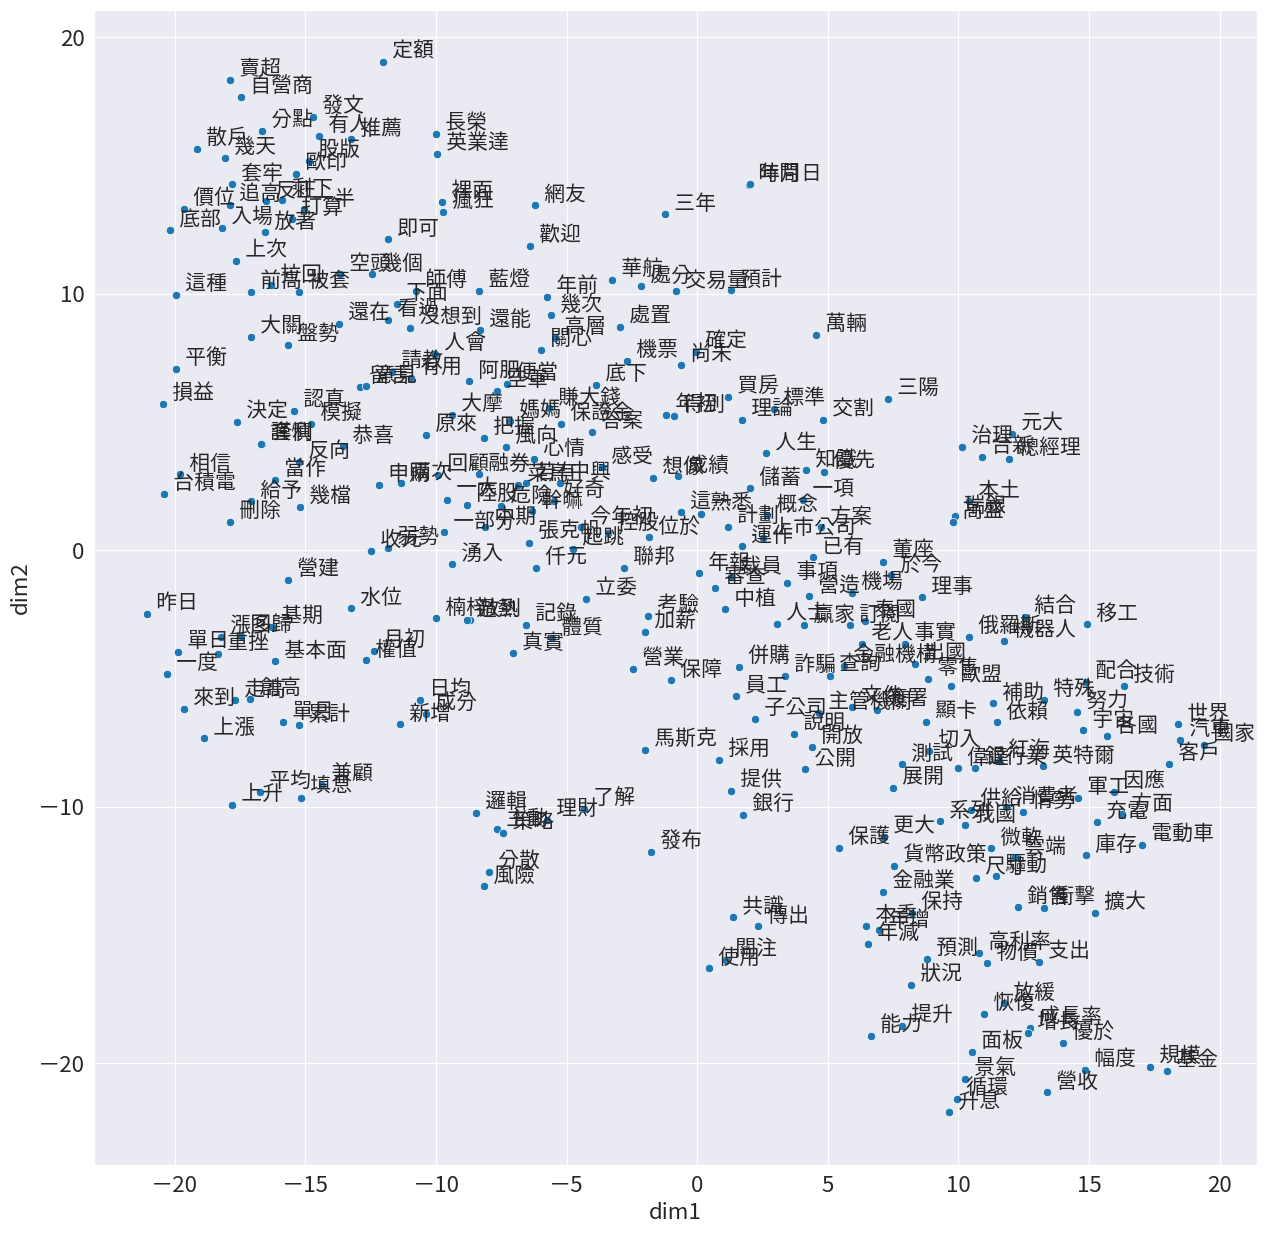

In [ ]:
plotScatter(word_df)

###### 3D 散狀圖

In [ ]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


將字分群

In [ ]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.4 MB/s eta 0:00:00


In [ ]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [ ]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



* 紫色:時間
* 橘色:國家、政策
* 黃色:股票走勢

### Transformers Embeddings

#### 使用 Sentence-Transformer 套件   
參考資料：https://www.sbert.net/index.html

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

#### 中文 bert-base-chinese

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

#### 開始使用embedding做NLP任務
* 相似文件

In [ ]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

<ipython-input-75-ba0ea2bb5f29>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,[標的]星宇航空座艙科技點滿多,標的星宇航空分類討論分析正文剛剛看到頻道邦尼幫你測試星宇的經濟艙有什麼東西快充雖然實測都不到...
1,2,Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%,今天沒意外準備反彈南山人壽已經澄清部位非常少股價根本過度反應反彈最少至於潤泰新存股也是可以的...
2,3,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,技術分析的問題是公說公有理婆說婆有理你一旦說他沒道理就有屁孩會來跟你說是學藝不精但其實都是畫...
3,4,Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?,有一招技術分析你可能聽過就是創新高的股票上無壓力會繼續延伸氣勢簡單來說就是去追突破壓力的股票...
4,5,[新聞]外資大砍金融股！中信金遭賣15.73萬張最,原文標題外資大砍金融股中信金遭賣萬張最慘新光金玉山金同步遭砍原文連結發布時間年月日週二上午記...


In [ ]:
corpus_embeddings = bert_ch.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [新聞]【Yahoo來選股】首季進入倒數！投信持股1

 資料集中前五相似的文章:
[新聞]【Yahoo來選股】首季進入倒數！投信持股1 (Score: 1.0000)
[新聞]旺季到台股ETF逢低布局 (Score: 0.9872)
[新聞]台股基金定期定額升溫 (Score: 0.9870)
[新聞]選後大盤漲定了回檔布局攻萬九 (Score: 0.9866)
[新聞]台股／台股第三季投資重點曝光5字訣要注 (Score: 0.9864)






In [ ]:
query_num = 10

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?

 資料集中前五相似的文章:
Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎? (Score: 1.0000)
Re:[請益]當沖高手是看什麼決定當天做多/做空 (Score: 0.9759)
[請益]心態崩想改買穩健ETF (Score: 0.9758)
Re:[請益]要降息了，美債是不是送分題？ (Score: 0.9750)
[請益]怎樣判斷是不是一個好的停損？？ (Score: 0.9750)






### 分類任務

In [ ]:
udn = pd.read_csv("./data/Stock_data.csv")
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/home-sale/M.1709223923....,[請益]兩房物件請益,2024-03-01 00:25:19,a96932000,home_sale,"不好意思又來叨擾房版了\n\n目前有看到高雄兩個物件,感覺各有勝負,想詢問看看版上的意見\n...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""themlb09"", ""...",220.143.164.133,2024-03-01 01:46:26,ptt
1,2,https://www.ptt.cc/bbs/home-sale/M.1709232819....,[請益]冠德安沐居要每坪200萬，冠德大直綻每坪,2024-03-01 02:53:37,gigaman,home_sale,請問各位先進，冠德安沐居要每坪200萬，冠德大直綻每坪160萬，雖然都在捷運出口，但\n也比...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""luckysmallsu...",42.70.108.144,2024-03-02 01:42:37,ptt
2,3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,jump0517,home_sale,連結：\nhttps://money.udn.com/money/story/5621/78...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fatpigbgman""...",1.168.65.178,2024-03-02 01:42:37,ptt


In [ ]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,請益兩房物件請益不好意思又來叨擾房版了目前有看到高雄兩個物件感覺各有勝負想詢問看看版上的意見...,https://www.ptt.cc/bbs/home-sale/M.1709223923....,home_sale
1,請益冠德安沐居要每坪萬冠德大直綻每坪請問各位先進冠德安沐居要每坪萬冠德大直綻每坪萬雖然都在捷...,https://www.ptt.cc/bbs/home-sale/M.1709232819....,home_sale
2,新聞台灣金聯土地未運用有原因駁斥養地炒連結內文台灣金聯土地未運用有原因駁斥養地炒房說媒體報導...,https://www.ptt.cc/bbs/home-sale/M.1709249161....,home_sale
3,情報好房網月房價好房網重點縣市成交漲跌排行點選區域實價登錄趨勢年月重點縣市實價登錄漲跌排行新...,https://www.ptt.cc/bbs/home-sale/M.1709251729....,home_sale
4,新聞桃園版香榭大道要來了鐵路地下化將釋地範響出畫站次的在規任榭桃均桃參考這篇還在說沒發包出去...,https://www.ptt.cc/bbs/home-sale/M.1709252693....,home_sale


In [ ]:
udn["embeddings"] = udn.content.apply(lambda x: bert_ch.encode(x))
udn.head(3)

,content,artUrl,artCatagory,embeddings
0,請益兩房物件請益不好意思又來叨擾房版了目前有看到高雄兩個物件感覺各有勝負想詢問看看版上的意見...,https://www.ptt.cc/bbs/home-sale/M.1709223923....,home_sale,"[0.24407408, 0.036900155, -0.062483586, 0.1419..."
1,請益冠德安沐居要每坪萬冠德大直綻每坪請問各位先進冠德安沐居要每坪萬冠德大直綻每坪萬雖然都在捷...,https://www.ptt.cc/bbs/home-sale/M.1709232819....,home_sale,"[0.43097487, 0.12077897, -0.09917401, 0.404692..."
2,新聞台灣金聯土地未運用有原因駁斥養地炒連結內文台灣金聯土地未運用有原因駁斥養地炒房說媒體報導...,https://www.ptt.cc/bbs/home-sale/M.1709249161....,home_sale,"[0.47411, 0.05409032, -0.13783132, -0.10163336..."


In [ ]:
data = udn.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
2351  0.312426 -0.068500 -0.431661  0.261032 -0.100590 -0.036990 -0.021201   
3943  0.580146  0.179587 -0.244553  0.052789 -0.125861  0.067658 -0.119948   
4593  0.523381  0.027680 -0.150247  0.203215  0.243080 -0.131190 -0.178439   
384   0.505848  0.088094 -0.314746  0.223174 -0.230788  0.215456 -0.164392   
3965  0.639452 -0.152544 -0.369263  0.342497 -0.024080 -0.050900 -0.125030   

           7         8         9    ...       758       759       760  \
2351 -0.018231 -0.146411 -0.322397  ...  0.201521 -0.195446  0.145009   
3943 -0.211887 -0.399000 -0.425595  ...  0.108014 -0.071715  0.141527   
4593 -0.005145 -0.276646 -0.259194  ...  0.153968 -0.044627  0.250804   
384  -0.081032 -0.137871 -0.408566  ...  0.145590 -0.208552  0.152318   
3965 -0.016901 -0.128349 -0.419699  ...  0.150053 -0.225829  0.229463   

           761       762       763       764       765       766       767  
2351  0.031921 

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred[:10])

['home_sale' 'home_sale' 'home_sale' 'Stock' 'home_sale' 'home_sale'
 'Stock' 'Stock' 'Stock' 'Stock']


In [ ]:
from sklearn.metrics import classification_report

#### 邏輯式回歸模型分數

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Lifeismoney       0.98      0.97      0.98       115
       Stock       0.98      0.98      0.98       817
   home_sale       0.97      0.97      0.97       596

    accuracy                           0.97      1528
   macro avg       0.98      0.97      0.98      1528
weighted avg       0.97      0.97      0.97      1528



#### 與DTM的預測分數做比較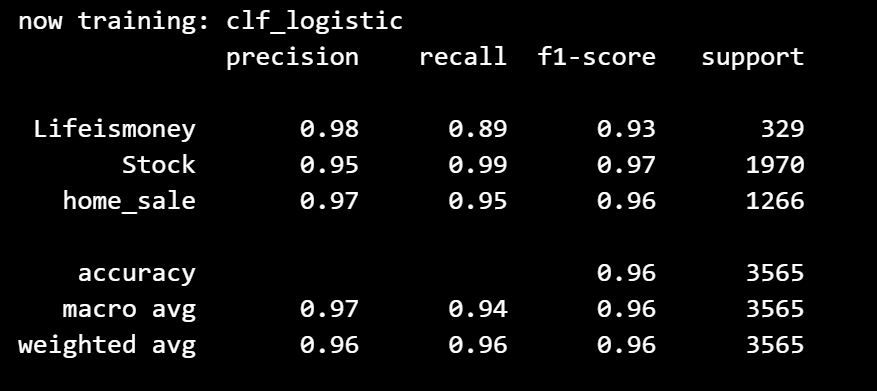